In [10]:
# Install a package BioConductor ExperimentHub to access the example data
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
BiocManager::install("ExperimentHub")

# Install glmnet for LASSO and Elastic Net regression
install.packages("glmnet")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11 ucrt)

Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.5.0/library
  packages:
    lattice, mgcv

Old packages: 'curl', 'data.table', 'generics', 'gh', 'openssl', 'pkgbuild',
  'pkgdown', 'promises', 'recipes', 'sparsevctrs', 'zip'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ExperimentHub'"
Installation paths not writeable, unable to 

In [11]:
library("BiocManager")
library("ExperimentHub")
library("glmnet")

# Problem 9: Microbiome data

Download this dataset from BioConductor.

In [12]:
eh = ExperimentHub()
data = eh[["EH361"]]

curatedMetagenomicData not installed.
  Full functionality, documentation, and loading of data might not be possible without installing

loading from cache



In this dataset, for each of $N_{\textrm{obs}}$ patients, the presence of $N_{\textrm{dim}}$ species of microbe was measured.
In addition, the disease state of the patient was measured, which can be "n" (no cancer), "adenoma" (precancerous), or "cancer".
For simplicity, let's only use the "n" and "cancer" states (and remove the adenomas).

In [ ]:
#colnames(data)
#rownames(data)
#data$disease

datacancerNoCancer = data[, data$disease %in% c("n", "cancer")]
dataCancerNoCancer$disease

[1] "n"      "n"      "n"      "cancer" "n"      "n"      "n"      "n"     
  [9] "cancer" "n"      "n"      "n"      "n"      "n"      "cancer" "n"     
 [17] "n"      "n"      "cancer" "cancer" "n"      "cancer" "cancer" "n"     
 [25] "n"      "n"      "n"      "cancer" "n"      "n"      "cancer" "cancer"
 [33] "cancer" "n"      "cancer" "n"      "n"      "n"      "n"      "n"     
 [41] "cancer" "cancer" "n"      "cancer" "n"      "n"      "cancer" "cancer"
 [49] "cancer" "cancer" "cancer" "n"      "n"      "cancer" "n"      "n"     
 [57] "cancer" "cancer" "cancer" "n"      "cancer" "n"      "cancer" "n"     
 [65] "n"      "cancer" "cancer" "cancer" "cancer" "cancer" "cancer" "cancer"
 [73] "cancer" "cancer" "n"      "n"      "n"      "n"      "n"      "cancer"
 [81] "cancer" "n"      "cancer" "n"      "cancer" "cancer" "n"      "cancer"
 [89] "n"      "n"      "n"      "cancer" "cancer" "n"      "n"      "cancer"
 [97] "cancer" "cancer" "cancer" "cancer" "cancer" "cancer" "n"      "n"     
[105] "n"      "cancer" "n"      "n"      "n"      "n"      "n"      "n"     
[113] "cancer" "cancer"

## Question i

Inspect the data.

How many patients are there ($N_{\textrm{obs}}$)?

How many species of microbe were measured ($N_{\textrm{dim}}$)?


In [14]:
ncol(dataCancerNoCancer)
nrow(dataCancerNoCancer)

Samples 
    114

Features 
    1505

# Answer i
- There are 114 patients, that is, $N_{\text{obs}}$ = 114.
- There are 1505 patients, that is, $N_{\text{dim}}$ = 1505.

## Question ii

In generalized linear regression (glm) model, the probability that a patient has cancer, given the presence of microbes $X_1,... X_{N-\textrm{dim}}$ is

$p = \frac{\operatorname{exp} (\beta_1 X_1 + ... )}{1+\operatorname{exp}\left( \beta_1 X_1 + ... \right)}$.

This model has a likelihood function $L(\beta_1, ... \beta, Y_1,...)$ you can see [here](https://en.wikipedia.org/wiki/Generalized_linear_model). 
Simply using the maximum likelihood approach is impossible here, since $N_{\textrm{dim}}>N_{\textrm{obs}}$. 

On the other hand, LASSO regression maximizes $L + \lambda \sum_i^n | \beta |$.

Perform LASSO regression for a sweep over $\lambda$.
Plot the value of all the parameters $\beta_i$ versus $\lambda$.


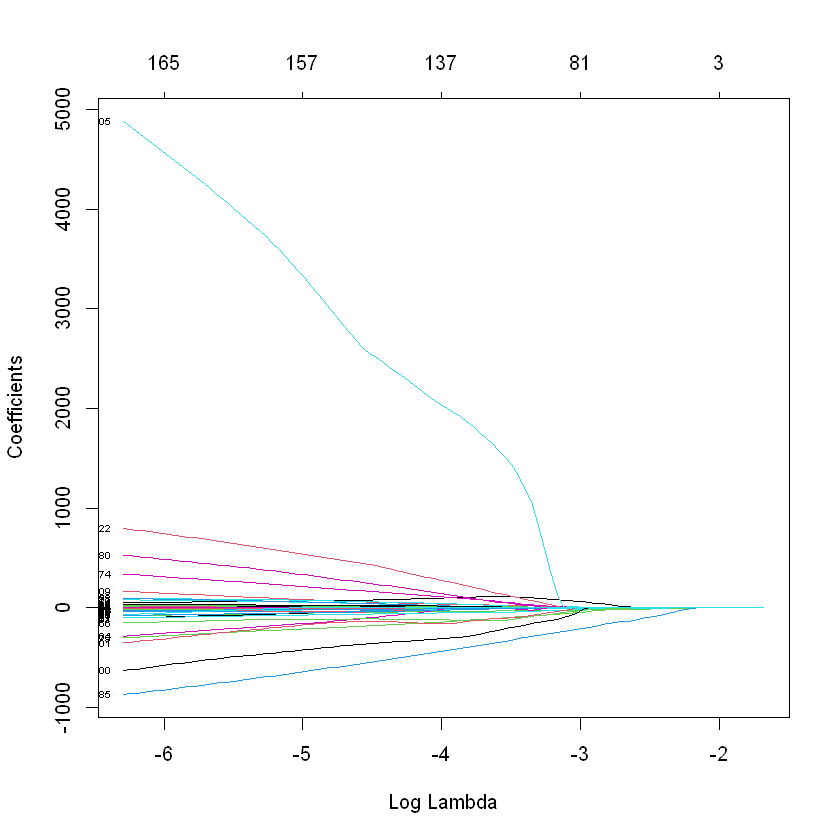

In [15]:
y = factor(dataCancerNoCancer$disease)
x = t(exprs(dataCancerNoCancer))

lassoFit = glmnet(y=y, x=x, family="binomial")

par(bg = "white")
plot(lassoFit, xvar = "lambda", label = TRUE)

Perform cross-validation for each value of $\lambda$.
What value of $\lambda$ minimizes the cross-validation error?

The value of lambda that minimizes the cross-validation error is : 0.06376534 


               
confusionMatrix cancer  n
         cancer     44  2
         n           9 59

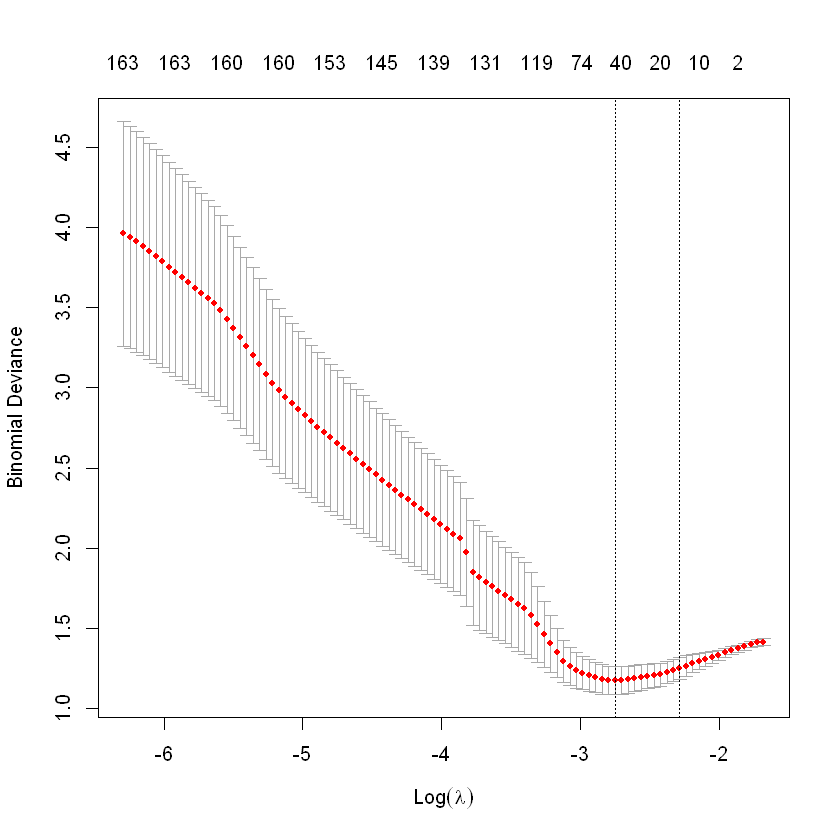

In [16]:
crossValidationOutput <- cv.glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)), family="binomial")
par(bg = "white")
plot(crossValidationOutput)

bestLambda = crossValidationOutput$lambda.min
cat("The value of lambda that minimizes the cross-validation error is :", bestLambda, "\n")
confusionMatrix = predict(lassoFit, newx = t(exprs(dataCancerNoCancer)), type="class",s=bestLambda)
table(confusionMatrix, dataCancerNoCancer$disease)

## 3.  Elastic Net regression

The characteristic feature of Ridge regression is the penalty

$$\mathrm{log}\left(L(\beta)\right) - \lambda \sum_i  \beta_i ^2,$$

while the penalty for Lasso regression is

$$\mathrm{log}\left(L(\beta)\right) - \lambda \sum_i | \beta_i |.$$

In this Problem Set, we explore the penalty

$$\mathrm{log}\left(L(\beta)\right) - \lambda \left(\alpha \sum_i | \beta_i | +  (1-\alpha) \sum_i  \beta_i ^2\right),$$

which is called __Elastic Net__.  

i) In parameter space, Ridge Regression corresponds to finding optimal parameters on a circle, while LASSO regression corresponds to finding optimal parameters on a diamond. What shape does Elastic Net correspond to?

Answer: Using the code below the shape for an elastic net is plotted. Looking at the shape it looks like a diamond whose vertexes are still pointy, and whose edges are rounded.

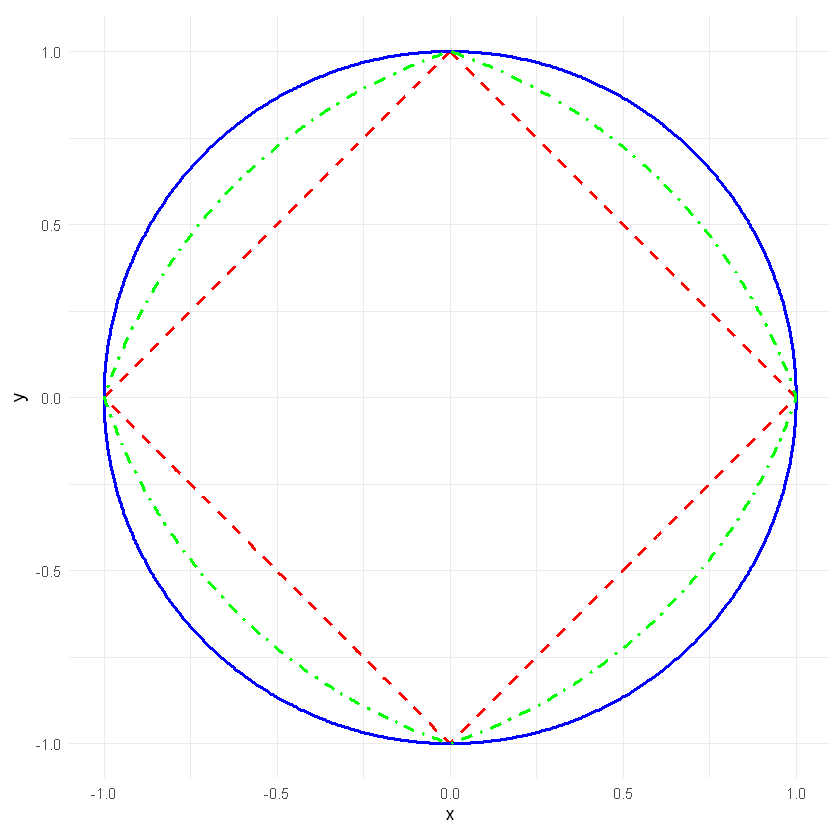

In [22]:
# Load required package
library(ggplot2)

# Define a grid of x and y values
x_vals <- seq(-1.5, 1.5, length.out = 500)
y_vals <- seq(-1.5, 1.5, length.out = 500)
grid <- expand.grid(x = x_vals, y = y_vals)

# Compute function values
grid$L1      <- abs(grid$x) + abs(grid$y)
grid$L2      <- grid$x^2 + grid$y^2
alpha <- 0.5
grid$Hybrid  <- alpha * (abs(grid$x) + abs(grid$y)) + (1 - alpha) * (grid$x^2 + grid$y^2)

# Plot contours
ggplot(grid, aes(x = x, y = y)) +
  geom_contour(aes(z = L1), breaks = 1, color = "red", size = 1, linetype = "dashed") +
  geom_contour(aes(z = L2), breaks = 1, color = "blue", size = 1, linetype = "solid") +
  geom_contour(aes(z = Hybrid), breaks = 1, color = "green", size = 1, linetype = "dotdash") +
  coord_equal() +
  theme_minimal()


ii). The `glmnet` package was built for Elastic Net regression. Look up the [glmnet package help files](https://www.rdocumentation.org/packages/glmnet/versions/3.0-2/topics/glmnet) to find out how to perform Elastic Net regression for a specific $\alpha$. Do this for $\alpha=0.5$, and return the confusion matrix.

In [23]:
# Setting alpha = 0.5 for Elastic Net
elasticNetCV <- cv.glmnet(y = factor(dataCancerNoCancer$disease),
                          x = t(exprs(dataCancerNoCancer)),
                          family = "binomial",
                          alpha = 0.5)

bestLambda <- elasticNetCV$lambda.min
preds <- predict(elasticNetCV, newx = t(exprs(dataCancerNoCancer)), s = bestLambda, type = "class")

# Confusion matrix
table(Predicted = preds, Actual = dataCancerNoCancer$disease)

         Actual
Predicted cancer  n
   cancer     49  0
   n           4 61

iii) Perform a sweep over $\alpha=0$ to $\alpha=1$. Plot the number of species included versus $\alpha$.

Hint: The cv.glmnet output object has a returns a value `$nzero`, which is the number of nonzero factorso, which is the number of species desired.  

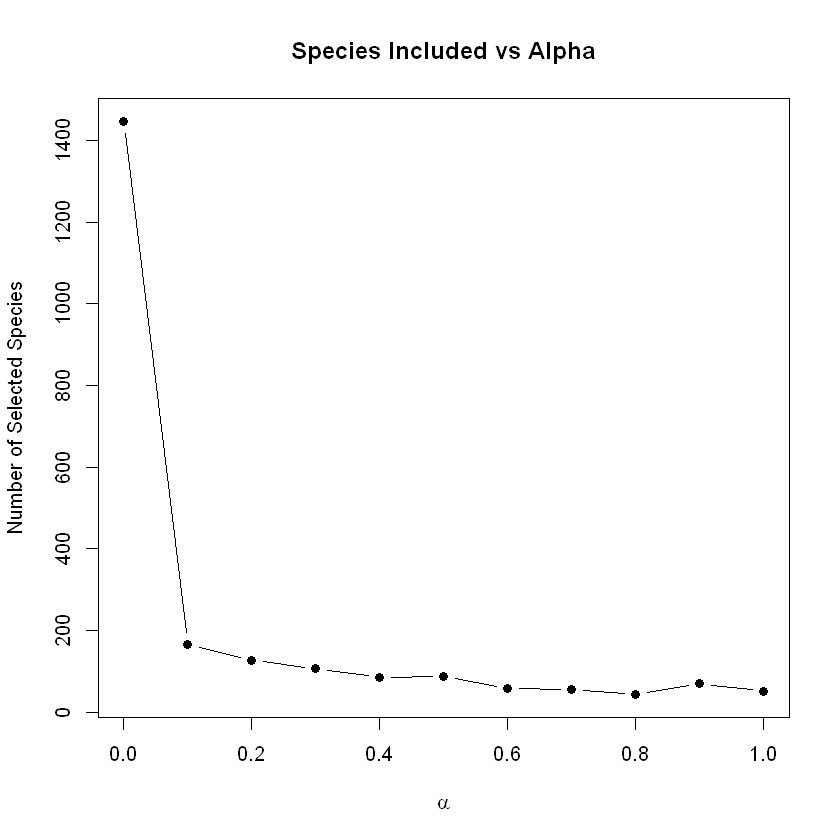

In [25]:
alphas <- seq(0, 1, by = 0.1)
nzeros <- numeric(length(alphas))

for (i in seq_along(alphas)) {
  fit <- cv.glmnet(y = factor(dataCancerNoCancer$disease),
                   x = t(exprs(dataCancerNoCancer)),
                   family = "binomial",
                   alpha = alphas[i])
  # Number of nonzero coefficients at best lambda
  nzeros[i] <- fit$nzero[which(fit$lambda == fit$lambda.min)]
}

# Plot alpha vs number of selected species
par(bg = "white")
plot(alphas, nzeros, type = "b", pch = 16,
     xlab = expression(alpha), ylab = "Number of Selected Species",
     main = "Species Included vs Alpha")


iv) What $\alpha$ value minimizes the number of false positives (non-cancer patients that are predicted to have cancer)? What $\alpha$ value minimizes the number of false negatives (cancer patients that are predicted to not have cancer)?


Alpha(s) minimizing false positives: 0, 0.05, 0.2, 0.25, 0.3, 0.4, 0.8, 0.95, 1 
Alpha(s) minimizing false negatives: 0.2, 0.25 


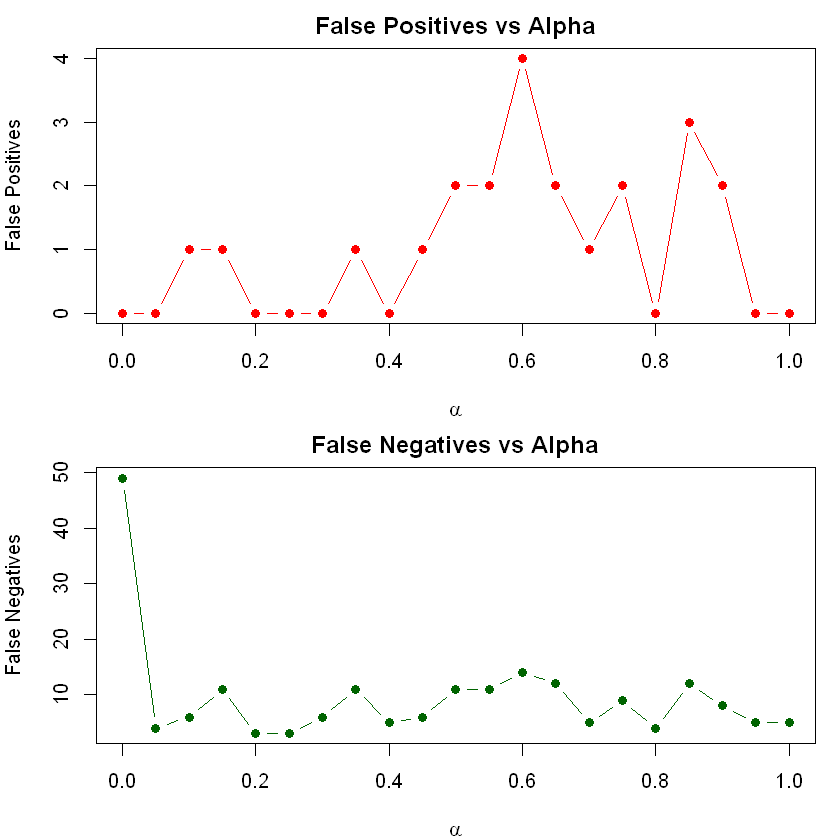

In [35]:
alphas <- seq(0, 1, by = 0.05)
nzeros <- numeric(length(alphas))
false_positives <- numeric(length(alphas))
false_negatives <- numeric(length(alphas))

true_labels <- factor(dataCancerNoCancer$disease)

for (i in seq_along(alphas)) {
  fit <- cv.glmnet(y = true_labels,
                   x = t(exprs(dataCancerNoCancer)),
                   family = "binomial",
                   alpha = alphas[i])
  bestLambda <- fit$lambda.min
  preds <- predict(fit, newx = t(exprs(dataCancerNoCancer)), s = bestLambda, type = "class")
  cm <- table(Predicted = preds, Actual = true_labels)
  
  # False positives: predict Cancer but actually NoCancer
  false_positives[i] <- ifelse("cancer" %in% rownames(cm) & "n" %in% colnames(cm),
                               cm["cancer", "n"], 0)
  # False negatives: predict NoCancer but actually Cancer
  false_negatives[i] <- ifelse("cancer" %in% rownames(cm) & "cancer" %in% colnames(cm),
                               cm["n", "cancer"], 0)
}

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1), bg="white")
# Plot false positives vs alpha
plot(alphas, false_positives, type = "b", pch = 16, col = "red",
     xlab = expression(alpha), ylab = "False Positives",
     main = "False Positives vs Alpha")

# Plot false negatives vs alpha
plot(alphas, false_negatives, type = "b", pch = 16, col = "darkgreen",
     xlab = expression(alpha), ylab = "False Negatives",
     main = "False Negatives vs Alpha")


min_fp_alpha <- alphas[false_positives == min(false_positives)]
min_fn_alpha <- alphas[false_negatives == min(false_negatives)]

cat("Alpha(s) minimizing false positives:", paste(min_fp_alpha, collapse = ", "), "\n")
cat("Alpha(s) minimizing false negatives:", paste(min_fn_alpha, collapse = ", "), "\n")

Based on the above plots, choosing $\alpha = 0.25$ will be good as it minimized both false positives and false negatives.